# Part 1 ‑ Exploratory Data Analysis

</font> The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

## Answer to Part 1

We load the JSON dataset onto our df dataframe.

In [2]:
import pandas as pd

df = pd.read_json(r"logins.json")
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


We resample the time series dataframe in 15-minute intervals then aggregate it by count.

In [3]:
#resampling df to 15-minute intervals
df_logins = df.resample("15min", on="login_time").count()

#cleaning up df
df_logins.index.name = "idx"
df_logins.reset_index(inplace=True)
df_logins.rename({"login_time":"logins"}, axis=1, inplace=True)

#show
df_logins.head()

,idx,logins
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


We extract the hour and day components from the datetime object. We also identify whether the timestamp correspond to day or night (using AM vs. PM).

In [4]:
#extracting hours and days
df_logins["hour"] = df_logins["idx"].dt.hour
df_logins["day"] = df_logins["idx"].dt.day_name()

#giving AM/PM labels
day_or_night = lambda row: "AM" if row in range(0,12) else "PM"
df_logins["AM-PM"] = df_logins["hour"].apply(day_or_night)

#show
display(df_logins.head())

,idx,logins,hour,day,AM-PM
0,1970-01-01 20:00:00,2,20,Thursday,PM
1,1970-01-01 20:15:00,6,20,Thursday,PM
2,1970-01-01 20:30:00,9,20,Thursday,PM
3,1970-01-01 20:45:00,7,20,Thursday,PM
4,1970-01-01 21:00:00,1,21,Thursday,PM


Since the logins are aggregated by count, we can group entries that occurred in the same day of the week and aggregate them by summation.

We can also get the average daily login per day of the week using mean.

**Insight**: The `df_day` shows us the what day of the week is busiest. Clearly, Friday and weekends are when there are most logins. Mondays are the slowest and in fact, on average, there are about the same amount of logins that occur on Saturdays as *two* Mondays. And to be clear, the total number of logins signify the aggregate logins in the specific timeframe provided by the dataset -- a more reliable indicator then is the `daily_avg`.

In [5]:
#getting total logins per day of week
df_day = df_logins.groupby("day").sum()[["logins"]]

#getting average daily logins per day of week
df_day["daily_avg"] = df_logins.groupby("day").mean()[["logins"]]

#show
display(df_day)

,logins,daily_avg
day,,
Friday,15208,10.561111
Monday,8823,6.213380
Saturday,19377,13.456250
Sunday,18167,12.615972
Thursday,11960,8.794118
Tuesday,9268,6.895833
Wednesday,10339,7.692708


We can also identify at what time the most logins occur by identifying the hourly_avg across all days.

**Insight**: It appears that the least amount of average logins occur during the morning rush hour window between 7am and 9am, and the busiest is during really late hours (10pm onwards). This tells us that Ultimate is used less for everyday travel than getting around for a night out.

In [6]:
#getting total logins per hour
df_hour = df_logins.groupby("hour").sum()[["logins"]]

#getting average hourly logins per hour of day
df_hour["hourly_avg"] = df_logins.groupby("hour").mean()[["logins"]]

#show
display(df_hour)

,logins,hourly_avg
hour,,
0,5993,14.688725
1,6317,15.482843
2,5800,14.215686
3,4831,11.840686
4,5034,12.338235
5,2945,7.218137
6,1138,2.789216
7,815,1.997549
8,818,2.004902


To get a clearer picture, the df_total takes into account day and night hours per week of day.

**Insight**: This highlights our finding that the app is used more often at night and much more frequently on weekends than weekdays. It can be said that Ultimate has not replaced conventional everyday driving for commuting.

In [7]:
#aggregating by sum
df_total = df_logins.groupby(["day", "AM-PM"]).sum()[["logins"]]

#aggregating by mean
df_total["total_avg"] = df_logins.groupby(["day", "AM-PM"]).mean()[["logins"]]

#show
display(df_total)

logins  total_avg
day       AM-PM                   
Friday    AM       5924   8.227778
          PM       9284  12.894444
Monday    AM       3905   5.423611
          PM       4918   7.025714
Saturday  AM      10217  14.190278
          PM       9160  12.722222
Sunday    AM      10351  14.376389
          PM       7816  10.855556
Thursday  AM       5153   7.668155
          PM       6807   9.893895
Tuesday   AM       3961   5.894345
          PM       5307   7.897321
Wednesday AM       4570   6.800595
          PM       5769   8.584821

**Insight**: We can visualize the login trend below. There are three *spikes* in usage that we can characterize as the following:
1. Lunch hours during weekdays
2. Going out on Friday/Saturday/Sunday nights
3. Getting home past midnight after the night out on Saturdays/Sundays

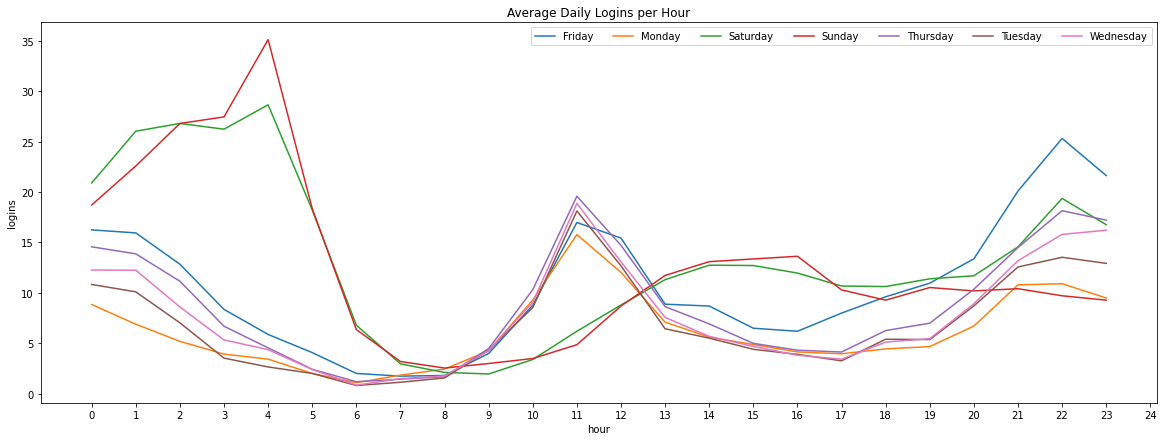

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

#getting average daily logins per hour
df_total = df_logins.groupby(["hour", "day"]).mean().reset_index()

#plotting df
f, axes = plt.subplots(figsize=(20,7))
ax = sns.lineplot(x="hour", y="logins", data=df_total, hue="day")
ax.legend(loc="upper right", ncol=8)
ax.set(title="Average Daily Logins per Hour")
plt.xticks(range(0,25))

#display plot
plt.show()


**Insight**: The chart below depicts the total daily logins throughout the entire timeframe of the dataset. The zig-zag pattern occurs because the resampling split days into AM and PM and the demand swings drastically when the logins are averaged out. Clearly, there is an unusual spike in activity in early April suggesting that it must have been a holiday or a special occasion in the serviced area.

<ipython-input-9-a84972c0fb44>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=df_daily["idx"].dt.day, \


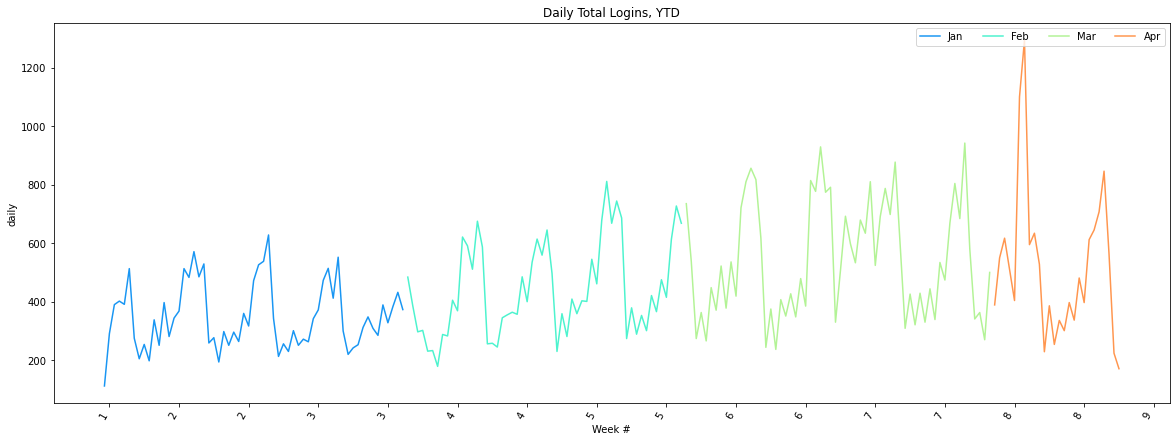

In [9]:
import matplotlib.dates as mdates

#resampling df to daily intervals
df_daily = df.resample("12H", on="login_time").count()

#cleaning up df
df_daily.index.name = "idx"
df_daily.reset_index(inplace=True)
df_daily.rename({"login_time":"daily"}, axis=1, inplace=True)

#extracting months
df_daily["month"] = df_daily["idx"].dt.month
df_daily["month"] = df_daily["month"].map({1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr"})

#plotting df
f, axes = plt.subplots(figsize=(20,7))
ax = sns.lineplot(x="idx", y="daily", data=df_daily, hue="month", palette="rainbow")
ax.legend(loc="upper right", ncol=5)
ax.set(title="Daily Total Logins, YTD", xlabel="Week #")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.set_xticklabels(labels=df_daily["idx"].dt.day, \
                   rotation=60, ha="right")

#display plot
plt.show()

# Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:</font>
a. How you will implement the experiment
b. What statistical test(s) you will conduct to verify the significance of the observation?
c. How you would interpret the results and provide recommendations to the city operations team along with any caveats.

### Answer to Part 2

We can compare pre-toll vs. post-toll ridership using A/B testing. If drivers being exclusive to one city really affects business then it must be because of lack of supply, extending the waiting times for riders and driving the cost higher as well. We can then use these characteristics as the metric as basis for comparison:

Compare daily average wait times (time driver arrives vs. time rider sends request) in either city prior to the change and after
Compare daily average price during rush hour (dollar per mile cost that includes surge pricing due to demand) prior to the change and after
Compare daily rate of denied service (i.e. how many times users are turned down for being too far) prior to the change and after
These parameters can simply be extracted from the internal database before and after the implementation of the reimbursement program. The hypothesis testing will be done on each of the three metrics above. Using the first item, average wait times, as an example, the null hypothesis would be that the difference between the two means will be zero (or that they are equal).

Now, since the statistic is daily, we can use a timeframe (say, 20 days) in which each day is a trial of the experiment -- so it will be 20 days during without reimbursement period, compared with 20 days during with reimbursement period. This will ensure randomness as long as this sample is not more than 10% of the actual length of the period (so the program must go on for at least 200 days).

From there, we can simulate the assumption of our null hypothesis by shuffling the labels of our means (half of the sample is randomly assigned as have occurred with reimbursement). Let's say that the target for the average wait time is a 10-second improvement -- our observed test statistic. The p-value is then the probability that a user waited 10-seconds less than when there was no reimbursement in these randomized circumstances. If this event happens less frequently than 5% of the time, then we know it's unlikely to occur. And so encountering a difference of 10-seconds waiting time is considered to be statistically significant.

If we disprove the null hypothesis (the status quo) for all the three metrics, then we have proven that the reimbursement program works. The next step then is to contrast the cost of the total reimbursements against the gains in revenue. And as contingency, also work out the impact of reverting back to the unsubsidized approach.

# Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in 2014. The data was pulled several months later; we consider a user retained if they were "active" (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

    1. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

    2.Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).</font>

# Answer to Part 3

In [10]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

The df is created from the JSON dataset and the dates are parsed so they're easily workable.

In [11]:
import pandas as pd
import json

#save file to memory
file = open("ultimate_data_challenge.json", "r")
dataset = file.read()
file.close()

#load file as JSON
data = json.loads(dataset)

#create df from JSON dataset
df = pd.DataFrame(data)

#parse dates
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"])
df["signup_date"] = pd.to_datetime(df["signup_date"])
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


A user is considered active when a user takes at least one trip during its first 30 days. The active series is created from this logic.

In [12]:
active = lambda row: 1 if row != 0 else 0
df["active"] = df["trips_in_first_30_days"].apply(active)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1


**Insight**: The distribution of users is shown below. There are significantly more active users. But to be clear, as we see in the first few entries to our `df`, an *inactive* user does not mean they do not generate revenue (and vice versa). The definition of *active* is somehow loose as we can have users that have signed up early on but did not use Ultimate's patronage until much later on. Users accumulate `avg_dist` but because there is no indication of *total number of miles* and/or *total number of trips*, there really isn't much to be drawn from the data provided.

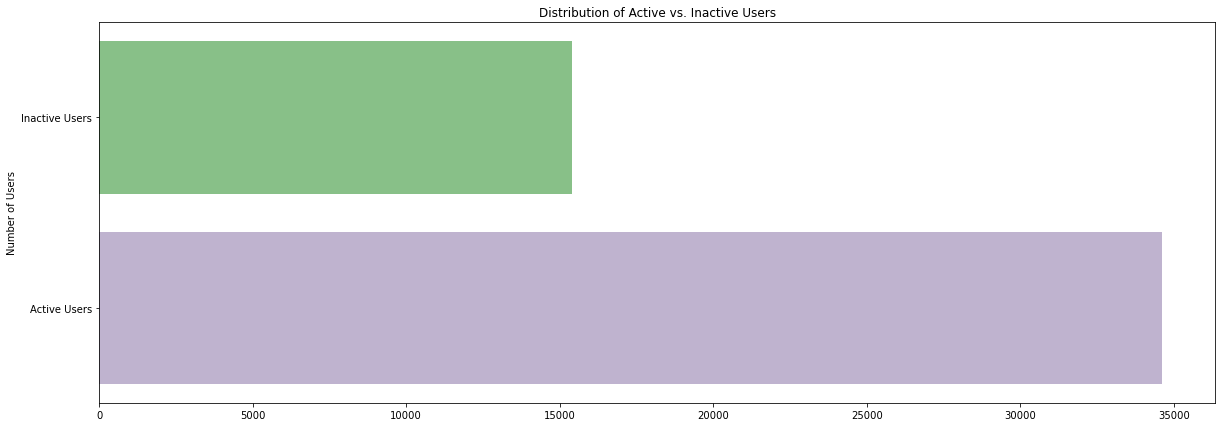

In [13]:
f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(y=df["active"], palette="Accent")
ax.set(title="Distribution of Active vs. Inactive Users", \
       xlabel="", ylabel="Number of Users")
ax.set_yticklabels(["Inactive Users", "Active Users"])
plt.show()

**Insight**: Since we are talking about distribution of *active* vs. *inactive*, we can alternatively see the proportion of the users in terms of percent:

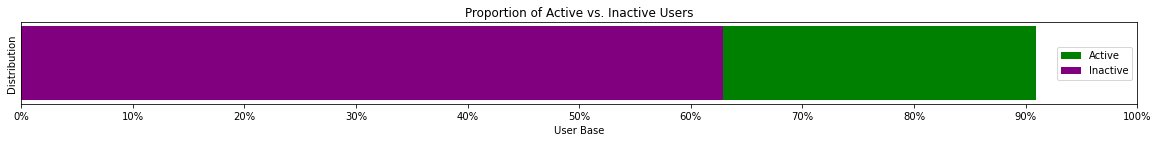

In [17]:
#active user stats
active_count = len(df[df["active"] == 1])
active_pct = active_count/len(df) * 100

#inactive user stats
inactive_count = len(df[df["active"] == 0])
inactive_pct = inactive_count/len(df) * 100

f, axes = plt.subplots(figsize=(20,1.5))

#stacked bar plot
plt.barh(y=0, width=inactive_pct, left=active_pct, color="green")
plt.barh(y=0, width=active_pct, color="purple")

#plot characteristics
plt.title("Proportion of Active vs. Inactive Users")
plt.xlabel("User Base")
plt.ylabel("Distribution")
plt.xticks(ticks = range(0, 111, 11), \
           labels = [str(i)+"%" for i in range(0, 101, 10)])
plt.yticks(ticks = [])
plt.legend(["Active", "Inactive"], loc="center right")

plt.show()

In order to predict if a user will retain in its sixth month, we first create the sixth_month_active column by getting the delta between the last_trip_date and the signup_date. If the result is higher than 30 * 5, then that user is definitely a user that has retained in their sixth month.

In [18]:
from datetime import timedelta

sixth_month_active = lambda row: 1 if \
                      row["last_trip_date"] - row["signup_date"] \
                      > timedelta(days=30*5) \
                      else 0

df["sixth_month_active"] = df.apply(sixth_month_active, axis=1)

df[["signup_date", "last_trip_date", "sixth_month_active"]].head()

,signup_date,last_trip_date,sixth_month_active
0,2014-01-25,2014-06-17,0
1,2014-01-29,2014-05-05,0
2,2014-01-06,2014-01-07,0
3,2014-01-10,2014-06-29,1
4,2014-01-27,2014-03-15,0


To simplify our df we get rid of datetime columns and keep only the continuous and numeric series.

In [19]:
df = df.drop(columns = ["last_trip_date", "signup_date"])
print(df.isna().any())

city                      False
trips_in_first_30_days    False
avg_rating_of_driver       True
avg_surge                 False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
active                    False
sixth_month_active        False
dtype: bool


**Insight**: We deal with *NaNs* in the ratings by replacing them with the population mean. The assumption is that when the user has not been rated, or has not given any rating, then the user did *not* elicit a particular experience and may have as well captured the overall "norm" experience. This is opposed to just dropping the NaNs from the columns.

In [20]:
import numpy as np

#replace avg_rating_by_driver NaNs with mean
mean = df["avg_rating_by_driver"].mean()
rating = lambda row: mean if np.isnan(row) else row
df["avg_rating_by_driver"] = df["avg_rating_by_driver"].apply(rating)

#replace avg_rating_of_driver NaNs with mean
mean = df["avg_rating_of_driver"].mean()
rating = lambda row: mean if np.isnan(row) else row
df["avg_rating_of_driver"] = df["avg_rating_of_driver"].apply(rating)

The series for the type of phone used to login on the app also contains NaNs. We simply categorize all the NaN values as Other since the NaN could either mean an unclassified phone or simply unrecognized.

In [21]:
other = lambda row: "Other" if type(row) != str else row
df["phone"] = df["phone"].apply(other)

print(df["phone"].unique())

['iPhone' 'Android' 'Other']


The tabulation below tells us that we've gotten rid of the NaN values in every column:

In [22]:
print(df.isna().any())

city                      False
trips_in_first_30_days    False
avg_rating_of_driver      False
avg_surge                 False
phone                     False
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver      False
active                    False
sixth_month_active        False
dtype: bool


To complete the preprocessing of our df, the following were performed:

From bool, the ultimate_black_user was instead mapped to 0 and 1.
The ultimate_black_user and active columns were converted to category types for computation speed.

In [23]:
#preprocessing
df["ultimate_black_user"] = df["ultimate_black_user"].map({False:0, True:1}).astype("category")
df["active"] = df["active"].astype("category")
df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,sixth_month_active
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0,1,0
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0,0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0,1,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9,1,1
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9,1,0


And now we split the data. The predictor X contains all the features while the target y corresponds to the sixth_month_active retention column.

In [24]:
from sklearn.model_selection import train_test_split

X = df[df.columns[:-1]]
y = df[df.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

display(X_train.head())
display(y_train.head())

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
28521,Winterfell,11,4.5,1.00,iPhone,0.0,0,48.6,2.06,4.7,1
45679,King's Landing,1,5.0,1.10,iPhone,6.5,1,90.3,3.26,4.9,1
33494,Winterfell,0,4.0,1.00,iPhone,0.0,1,50.0,3.10,4.5,0
37673,Astapor,0,5.0,1.00,Android,0.0,0,100.0,30.48,5.0,0
11486,Winterfell,0,5.0,1.38,iPhone,50.0,0,0.0,3.93,5.0,0


28521    1
45679    1
33494    0
37673    0
11486    0
Name: sixth_month_active, dtype: int64

Name: sixth_month_active, dtype: int64
We build a scikit-learn pipeline by first having two pipelines: the steps for continuous features, and the steps for discrete features.

The numeric_transformer simply scales the features so the magnitudes are relative. The categorical_transformer performs one-hot encoding on the categorical columns. After the preprocessing stages, the two pipelines diverge and get fed to the Random Forest classifier.

This entire pipeline is finally incorporated into Grid Search cross-validation.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#pipeline for numeric features
numeric_features = ["avg_dist", "avg_rating_by_driver", "avg_rating_of_driver", \
                    "avg_surge", "surge_pct", "trips_in_first_30_days", "weekday_pct"]
numeric_transformer = [("scaler", StandardScaler())]
numeric_transformer = Pipeline(numeric_transformer)

#pipeline for categorical features
categorical_features = ["city", "phone", "ultimate_black_user", "active"]
categorical_transformer = [("encoder", OneHotEncoder())]
categorical_transformer = Pipeline(categorical_transformer)

#divernce of the pipelines
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features), \
                  ("cat", categorical_transformer, categorical_features)])

#incorporating the random forest estimator
pipeline = Pipeline(steps=[("pre", preprocessor), \
                           ("rf", RandomForestClassifier(random_state = 42))])

#grid search parameters
params = {"rf__n_estimators" : [75, 100, 150],
          "rf__max_depth" : [5, 10, 15]}

#fitting the pipeline to the grid search
cv = GridSearchCV(pipeline, param_grid=params, cv=3)
cv.fit(X_train, y_train)

print(cv)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['avg_dist',
                                                                          'avg_rating_by_driver',
                                                                          'avg_rating_of_driver',
                                                                          'avg_surge',
                                                                          'surge_pct',
                                                                          'trips_in_first_30_days',
                                                                          'weekday_pct'

Using the best parameters, we get a score of 79.4% on our training set.

In [26]:
print(f"Best parameters: {cv.best_params_}")
print(f"Training accuracy score from tuned model: \
       {cv.best_score_*100:.1f}%")

Best parameters: {'rf__max_depth': 5, 'rf__n_estimators': 75}
Training accuracy score from tuned model:        79.4%


The tuned model is finally deployed to our testing set. For the metrics, we make use of accuracy in terms of classification and F1 score to take account false positives and false negatives. Our score is comparable to our training set score, meaning we have not overfitted.

In [27]:
from sklearn import metrics

y_pred = cv.predict(X_test)

test_accuracy = metrics.accuracy_score(y_test, y_pred)
test_f1_score = metrics.f1_score(y_test, y_pred)

print(f"Model accuracy: {test_accuracy*100:.2f}%")
print(f"Model F1 Score: {test_f1_score:.2f}")

Model accuracy: 79.00%
Model F1 Score: 0.43


We extract feature importance to get a better understanding of what goes behind the scenes on our model. The weights are then associated with their corresponding features.

In [28]:
pipeline.fit(X_train, y_train)

fe = pipeline.named_steps['rf'].feature_importances_

print(fe)

[0.28329547 0.10833294 0.09585472 0.07886955 0.09472234 0.07210908
 0.15230641 0.0147539  0.02194045 0.01045133 0.01232646 0.00118946
 0.01474489 0.01251428 0.0118985  0.00738249 0.00730775]


**Insight**: We can draw so much from the feature ranking. First of all, as suspected, the definition of *active* is indeed loose: being *active* or not in the first 30 days since sign up does NOT predict retention in six months well. It's about as irrelevant as what phone was used to create the account. What matters more is instead how many trips were taken during that stage.

What gives most predictability, though, is the **average distance**. The higher this average distance, the more likely the user retention. This makes sense because a user is more likely to use the service repeatedly *when it makes sense economically*. Because of scale, longer trips are cheaper and compete with taxi services and buses (may also be faster). But with shorter trips, factors like minimum fee could dissuade commuters and may opt for riding a bike instead, for example.

Long-term users would be the users who use it for commute and hence why the **weekday surge** ranked second. It tells us that retention is higher if people are convinced that Ultimate makes for a smart option to commute, rather than to use it just to go to a one-time event (like a conference).

So in all, it may not be highly effective to boost retention by giving introductory discounts to new users: it may acquire new signups, however, but not necessarily *retention*. What may work is to capitalize on long-distance commuters. For marketing, we can explicitly say that the service is much faster than buses and smarter than driving because of carpool lane privileges. But the smartest approach would be to come up with a patronage program where longer distance routes are incentivized with discounts, and continuous day-to-day trips are rewarded.

In [29]:
#replicating numeric_transformer of our pipeline
num_cols = df[numeric_features].columns
num_cols = num_cols.tolist()

#replicating categorical_transformer of our pipeline
cat_cols = pd.get_dummies(df[categorical_features]).columns
cat_cols = cat_cols.tolist()

#the column names are added together
cols = num_cols + cat_cols

#the column names are finally tied to our fe list
feature_importance = zip(cols, fe)
feature_importance = sorted(feature_importance, key=lambda x:x[1], reverse=True)

for i, j in feature_importance:
    print(f"Weight: {j:.3f} | Feature: {i}")

Weight: 0.283 | Feature: avg_dist
Weight: 0.152 | Feature: weekday_pct
Weight: 0.108 | Feature: avg_rating_by_driver
Weight: 0.096 | Feature: avg_rating_of_driver
Weight: 0.095 | Feature: surge_pct
Weight: 0.079 | Feature: avg_surge
Weight: 0.072 | Feature: trips_in_first_30_days
Weight: 0.022 | Feature: city_King's Landing
Weight: 0.015 | Feature: city_Astapor
Weight: 0.015 | Feature: phone_iPhone
Weight: 0.013 | Feature: ultimate_black_user_0
Weight: 0.012 | Feature: phone_Android
Weight: 0.012 | Feature: ultimate_black_user_1
Weight: 0.010 | Feature: city_Winterfell
Weight: 0.007 | Feature: active_0
Weight: 0.007 | Feature: active_1
Weight: 0.001 | Feature: phone_Other
